<a href="https://colab.research.google.com/github/zd2011/causal201/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS UA 9201 - Recitation 2
author: Judith Abécassis (judith.abecassis@nyu.edu) & Elise Dumas (elise.dumas@nyu.edu)
With many thanks to [Arvind Singh](https://www.imo.universite-paris-saclay.fr/~singh/) and [Matheus Facure Alves](https://matheusfacure.github.io/python-causality-handbook/landing-page.html) for inspiration.


In [ ]:
#Load useful libraries
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import CompareMeans 

### Problem 1 : Statistical test on the Titanic dataset

In this section, we will try to decipher the relationship between the ticket fare of Titanic passengers and their vital status after the sinking. Is there a correlation between how much you paid your ticket and the fact that you died in the end? 

1) Load the Titanic dataset. Are there missing values for the ticket fare (variable Fare)? For the vital status (variable Survived)?

In [ ]:
titanic = pd.read_csv("https://raw.githubusercontent.com/pandas-dev/pandas/main/doc/data/titanic.csv")
print(titanic.Survived.isnull().sum())
titanic.describe(include='all')

0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Correction : There is no missing value, neither for Survived, nor for Fare.

2) Derive the fare mean among survivors and among deceased passengers ? What can you hypothetize?

In [ ]:
titanic.groupby('Survived').Fare.mean()

titanic.groupby('Survived').agg("mean").Fare

Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64

Correction : On average, survivors tickets were more expensive than the ones of deceased passengers.

Let's denote by $F$ the ticket fare, $S$ the passenger survival status (1=survived,0= dead), $\mu_d = \mathbb{E}[F|S=0]$,  $\mu_s = \mathbb{E}[F|S=1]$, $\sigma_d^2 = \mathbb{V}ar[F|S=0]$, and $\sigma_s^2 = \mathbb{V}ar[F|S=1]$.

3) Using the Titanic data, compute estimators of $\mu_d$, $\mu_s$, $\sigma_d$ and $\sigma_s$. These estimators are denoted, respectively, by $\hat{\mu_d}$, $\hat{\mu_s}$, $\hat{\sigma_d}$ and $\hat{\sigma_s}$.

In [ ]:
means = titanic.groupby('Survived').Fare.mean()
stds = titanic.groupby('Survived').Fare.std()

mu_d = means[0]
print(f"An estimate of mu_d is {mu_d.round(2)}")
mu_s = means[1]
print(f"An estimate of mu_s is {mu_s.round(2)}")
sigma_d = stds[0]
print(f"An estimate of sigma_d is {sigma_d.round(2)}")
sigma_s = stds[1]
print(f"An estimate of sigma_s is {sigma_s.round(2)}")

An estimate of mu_d is 22.12
An estimate of mu_s is 48.4
An estimate of sigma_d is 31.39
An estimate of sigma_d is 66.6


We denote $\mu = \mu_d - \mu_s$ the average difference in fares among the two populations. Compute an estimate $\hat{\mu}$ of $\mu$ using the Titanic data.

In [ ]:
mu = mu_d - mu_s
print(f"An estimate of mu is {mu.round(2)}")

An estimate of mu is -26.28


Right, we have an estimator of the fare difference in deceased and survived passengers. But can we say that this difference is significantly different than 0 with a certain level of risk?

To answer this question, we proceed to a statistical test. We test the hypothesis $H_0: "\mu_d = \mu_s"$ against the hypothesis $H_1: "\mu_d \neq \mu_s"$.

We denote $n_d$ the number of deceased passengers and $n_s$ the number of survivors. We can show that, under $H_0$, (and under several other good asumptions that we won't develop here), 
$$
Z = \frac{\mu_d-\mu_s}{SE} ⟶ \mathcal{t}(n_d+n_s-2)
$$

where $t(d)$ is a Student distribution with $d$ degrees of freedom and 
$$
SE = \sqrt{\frac{(n_d-1)\hat{\sigma_d}^2 +(n_s-1)\hat{\sigma_s}^2}{n_s+ n_d -2}} \times \sqrt{\frac{1}{n_s}+ \frac{1}{n_d}}
$$

$Z$ is the test statistic.

4) Compute the empirical test statistic $Z^{emp}$ for the titanic dataset.

In [ ]:
#Compute SE
n = titanic.groupby('Survived').size()
n_d = n[0]
n_s = n[1]
print(f"There are {n_d} deceased passengers and {n_s} survivors.")
SE = np.sqrt(((n_d-1)*sigma_d**2 + (n_s-1)*sigma_s**2)/(n_d+n_s-2))
SE = SE*np.sqrt(1/n_s+1/n_d)
print(f"SE:{SE.round(3)}")
Z = (mu_d - mu_s)/SE
print(f"The test statistic equals {Z.round(3)}")

There are 549 deceased passengers and 342 survivors.
SE:3.31
The test statistic equals -7.939


5) We use a critical region of the form 
$K (Z) = \big\{|Z| \geq t\big\}$. What value of $t$ shoud you set to have a asymptotical confidence of 95% for the statistical test $H_0$ against $H_1$? Compute this value of $t$.

Correction: Under $H_0$, the test statistic $Z$ follows a Student distribution. To have $\mathbb{P}r(K(Z)) \leq 0.05$, we set $t$ as the 0.975th quantile of the Student distribution.

In [ ]:
df = n_s + n_d -2
print(df)
t = sps.t.ppf(0.975, df) #0.957th quantile of the normal distribution.
print(f"We use t: {t.round(2)}")

889
We use t: 1.96


5) Does the empirical value of the test statistic $Z^{emp}$ belong to the critical region? What can you conclude?

Correction : $|Z^{emp}| ≃ 7.94 > t$, so that the empirical test statistic belongs to the critical region. We reject $H_0$ and accept $H_1$ with a level of risk of $5\%$. This means that, we are pretty confident about the fact that there is a difference in the two means. In other words, the average fare paid by deceased passengers was significantly lower than the average fare paid by survivors.

6) Compute the p-value of your statistical test.

Correction :The $p$-value $p$ is such that $p=\mathbb{P}r \big( |Z| \geq Z^{emp}\big) ≃ \mathbb{P}r \big( |Z| \geq 7.94\big)$. 

In [ ]:
#P-above
P_above = 1- sps.t.cdf(abs(Z),df)

p = 2*(1-sps.t.cdf(abs(Z),df))
print(f'The p-value is : {p}')

The p-value is : 5.995204332975845e-15


The statistical test you have implemented is a classical test for means comparison between independent samples, often denoted as t-test or Student test. Of course, you should not implement this test by scratch each time you want to use it. By running the following code, compare your results with the results obtained from the statsmodels library.

In [ ]:
survived_fare = np.asarray(titanic[titanic.Survived == 1].Fare)
deceased_fare = np.asarray(titanic[titanic.Survived == 0].Fare)
print(CompareMeans.from_data(deceased_fare,survived_fare).summary())

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1    -26.2775      3.310     -7.939      0.000     -32.774     -19.781


In this problem, we used some statistical tools to show that there is a correlation between fares and survival status. Yet, we are still not dealing with causality. The statistical correlation between fares and survivalship is not sufficient to show that there is a causal link between these two variables. Basically, we still cannot answer the question : what would have happened if we had altered the ticket fares and nothing else? Would a deceased passenger would have survived if nothing changed except that he/she paid twice the price he had paid first?

Probably no. Indeed, there can be many other factors that may have influenced the survivorship status. Passengers with high fare may be better swimmers; passengers with high fare could have been rescued earlier; etc...

### Problem 2 : Introduction to the counterfactual framework

For this section, we split the ticket fares in two : "Low fare" and "High fare". Formally, we state $F=1$ for high fare and $F=0$ for low fare passengers. We denote by $Y^{low}$ the survival status that would have been observed had the passenger paid a low fare and $Y^{high}$ the survival status that would have been observed had the passenger paid a high fare. **We also assume that we were rewarded with godlike powers so that we have access to the value of both counterfactual outcomes.**

1) Load the new dataset (titanic_godlike.csv).

In [ ]:
titanic_godlike = pd.read_csv('titanic_godlike.csv')
titanic_godlike.head(10)

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_bin,Y_low,Y_high
0,1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,0
1,2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,1
2,3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0
3,4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,1
4,5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,0
5,6,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,0,0
6,7,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,0,0
7,8,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1,0,0
8,9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,1,1
9,10,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,1,1


2) Compute an estimate of the Average Treatment Effect (ATE). How can you interpret it? We recall that: 

$$
ATE = \mathbb{E}(Y^{high}-Y^{low})
$$

In [ ]:
ATE = np.mean(titanic_godlike.Y_high - titanic_godlike.Y_low)
print(f"ATE : {ATE.round(3)}")

ATE : -0.002


Correction : The Average Treatment Effect is very low in absolute value. This suggests that there is no causal effect of the ticket fare on the passenger survival status. In other words, the ticket fare alone does not seem to impact the survival status of the passenger. The correlation we found in problem 1 was probably not causation!

3) Compute an estimate of the Average Treatment Effect on the Treated (ATT). How can you interpret it? We recall that: 

$$
ATT = \mathbb{E}(Y^{high}-Y^{low}|F = 1)
$$

In [ ]:
titanic_treated = titanic_godlike[titanic_godlike.Fare_bin == 1]
ATT = np.mean(titanic_treated.Y_high - titanic_treated.Y_low)
print(f"ATT : {ATT.round(3)}")

ATT : -0.007


Correction : The ATT is very low in absolute value. This suggests that there is no causal effect of the ticket fare on the passenger survival status among passengers who paid a high fare ticket. In other words, considering only the kind of passengers who may have paid a high fare ticket, their survival status would not have changed much if they had paid a low fare ticket instead. In this case, ATE and ATT were very close with each other. We will see in the rest of the class that this is not always the case in real-world observational studies. Indeed, the effect of treatment may be different among individuals who are prone to be treated.

As an example, imagine we are interested in the effect of the intake of an anti-diabetic drug (for type II diabete) on breast tumor progression. To do so, we select a bunch of breast cancer patients in an anti-cancer center and collect the size of their tumor at diagnosis, the fact that they use (or not) the anti-diabetic drug during the 3 months following breast cancer diagnosis, and the size of their tumor 3 months after breast cancer diagnosis. We find that the given anti-diabetic drug does not have any causal effect on the breast tumor size on the whole population (ATE=0). Yet, the treated patients, *i.e.* the patients who took the anti-diabetic drug, most probably have different characteristics than the patients who did not use the drug in the months following diagnosis since, among others, most of them must be diabetic. In this case, it is possible that the effect the anti-diabetic drug have on breast cancer progression is influenced by diabete. Maybe, among patients who acutally took the drug, the anti-diabetic drug decreased significantly the breast tumor size (ATT < 0). This is an example where the ATE and the ATT differs due to treatment heterogeneity across populations. 

Well, in this setting, estimating the causal effects among the whole population (ATE) and the treated population (ATT) was quite easy, right? The real issue of causal inference is that we can never have access to the two counterfactuals in real-life. For the sake of this exercice we simulated them and assume that we have godlike powers. In practice, only one counterfactual can be observed for each individual and ATE and ATT cannot be exactly computed staightaway. We will see in the rest of the course how we can still estimate them from real-world observational data.

### Problem 3 (bonus) : Illustration of the central limit theorem

Let $(X_i)_{i\in\mathbb{N}}$ be a sequence of random samples independent and identically distributed (iid) from a distribution of finite mean $m$ and finite variance $\sigma^2$. We denote

$$\bar X_k = \frac 1 k (X_1 + \cdots + X_k)$$

Then: 

$$\sqrt{k}(\bar X_k - m) / \sigma $$

converges in distribution to $\mathcal{N}(0,1)$ when $k → +∞$. This is the central limit theorem. It basically means that the "normalized" sum of independent random variables tends toward a normal distribution, no matter the distribution followed by these variables, as long it has a finite mean and a finite variance. It is a very powerful  theorem in statistics, that we will widely use to derive convergence properties of causal inference estimators.

In this problem, we aim at illustrating the central limit theorem.
Let's assume that $X_i ∼ \mathcal{L}$ where $\mathcal{L}$ is the lognormal distribution, whose density is  

$$
f(x) = \frac{1}{x\sqrt{2\pi}}\exp\left(-\frac{\log^2(x)}{2}\right) \quad\hbox{ for } x \in ]0,+\infty[
$$

We give: 
$$
\mathbb{E}(X_1) = e^{\frac{1}{2}}
$$
and
$$
\mathbb{V}\text{ar}(X_1) = e(e-1)
$$

**Home exercice:** Derive the computation of the log-normal expectation and variance.

1) Using the library scipy.stats (loaded with the alias sps), simulate N independent samples of $\bar{X_k}$.
We *will* use $N = 10,000$ and $k = 1,000$.

In [ ]:
N = 10000 # Number of samples
K = 1000  # Number of terms of the sum

#lnl is the lognormal distribution
lnl = sps.lognorm(1)

sample = lnl.rvs(size=(N,K)) # We sample directly N*k values from the lognormal distribution
print(sample.shape)
XbarK = np.mean(sample, axis=1) # And we then compute the log-normal distribution.

NameError: ignored

2) Compute m and $\sigma$ (theoritical values).

In [ ]:
#We can compute directly the theoratical mean and standard deviation of the lognormal distribution from scipy.stats
m = lnl.mean() # Expectation
sigma = lnl.std()  # Standard deviation
#Or, alternatively, use the formula derived above
#m = np.exp(1/2)
#sigma = np.sqrt(np.exp(1)*(np.exp(1)-1))
print(f"Mean of the lognormal distribution: {m.round(2)}; Standard deviation of the lognormal distribution: {sigma.round(2)}")

Mean of the lognormal distribution: 1.65; Standard deviation of the lognormal distribution: 2.16


3) Using questions 1) and 2), compute N samples of
$$\sqrt{k}(\bar X_k - m) / \sigma $$

In [ ]:
G = np.sqrt(K)*(XbarK - m)/sigma 

4) Plot the empirical distribution $\sqrt{k}(\bar X_k - m) / \sigma$ and compare it with the density of $\mathcal{N}(0,1)$.

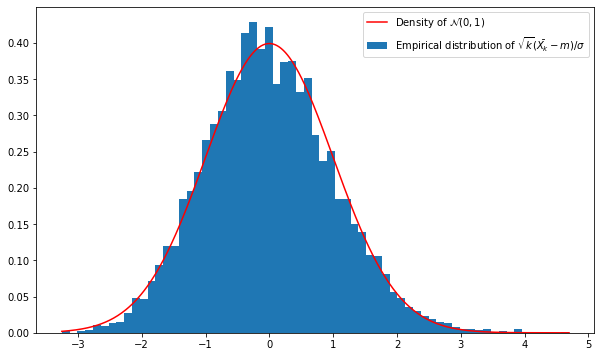

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(G, density=True, bins='auto',
         label=r"Empirical distribution of $\sqrt{k}(\bar{X_k} - m)/\sigma$") # exemple de LaTeX: attention à utiliser une raw string

X = np.linspace(np.min(G), np.max(G), 500) # discrétise l'intervalle d'affichage
plt.plot(X, sps.norm.pdf(X), "r", label="Density of $\mathcal{N}(0,1)$") # trace la densité gaussienne. 
plt.legend(loc='best')
plt.show()